In [1]:
!pip install ijson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.0/135.0 kB 4.0 MB/s eta 0:00:00


## Imports

In [2]:
import os
import zipfile
import json
import ijson
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
import joblib

from kaggle_secrets import UserSecretsClient

from glob import glob
from typing import List, Dict, Any, Optional
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

In [3]:
def collect_json_files(root_dir: str) -> List[str]:
    """Recursively collect all .json files from the nested folder structure."""
    pattern = os.path.join(root_dir, "**", "*.json")
    return glob(pattern, recursive=True)

In [4]:
def load_json_records_to_dataframe(file_paths: List[str]) -> pd.DataFrame:
    """Loads data from all JSON-files into DataFrame."""
    all_records = []
    
    for path in file_paths:
        try:
            with open(path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                if isinstance(data, list):
                    all_records.extend(data)
                else:
                    print(f"⚠️ File missed (not list): {path}")
        except Exception as e:
            print(f"❌ Error reading {path}: {e}")
    
    df = pd.DataFrame(all_records)
    return df

In [5]:
ROOT_DIR = "/kaggle/input/eyes-on-the-ground-image-data/EotG_data_final_no_git/ancillary_data/"
subfolders = ['sentinel', 'era5']

## Sentinel data collection

In [6]:
json_files = collect_json_files(ROOT_DIR + subfolders[0])
print(f"Found {len(json_files)} JSON files.")

Found 7040 JSON files.


In [7]:
df_senti = load_json_records_to_dataframe(json_files)
print(df_senti.head())

         date            product band    value farmer_unique_id  site_id
0  2020-01-11  COPERNICUS/S1_GRD   VH -14.5043          2635506     1670
1  2020-01-23  COPERNICUS/S1_GRD   VH -12.1374          2635506     1670
2  2020-02-04  COPERNICUS/S1_GRD   VH -17.4798          2635506     1670
3  2020-02-16  COPERNICUS/S1_GRD   VH -15.6007          2635506     1670
4  2020-02-28  COPERNICUS/S1_GRD   VH -12.2042          2635506     1670


In [8]:
df_senti.shape

(999494, 6)

In [9]:
df_senti['farmer_unique_id'].value_counts()

farmer_unique_id
MC026         8496
BS019         6832
BS028         4270
ME3154        3720
MC014         3422
              ... 
3173770        118
1221906715     118
2114148        118
1345391084     118
394191876      118
Name: count, Length: 3184, dtype: int64

In [10]:
df_senti['site_id'].value_counts()

site_id
2415     488
1076     488
1197     488
1318     488
1392     488
        ... 
8747     118
9702     118
9411     118
3862     118
11357    118
Name: count, Length: 6459, dtype: int64

## ERA5 data collection

In [11]:
def load_era5_dewpoint_dataframe(file_paths: List[str]) -> pd.DataFrame:
    """Loads dewpoint only ERA5 records from JSON-files safely."""
    rows = []

    for path in file_paths:
        try:
            with open(path, 'r', encoding='utf-8') as f:
                for item in ijson.items(f, 'item'):
                    if (
                        item.get("product") == "ERA5" and
                        item.get("band") == "dewpoint_2m_temperature"
                    ):
                        rows.append(item)
        except Exception as e:
            print(f"❌ Reading error {path}: {e}")
    
    return pd.DataFrame.from_records(rows)

In [12]:
json_files_era5 = collect_json_files(ROOT_DIR + subfolders[1])
print(f"Found {len(json_files_era5)} JSON files.")

Found 7040 JSON files.


In [13]:
df_era5 = load_era5_dewpoint_dataframe(json_files_era5)
print(df_era5.head())

         date product                     band     value farmer_unique_id  \
0  2020-01-01    ERA5  dewpoint_2m_temperature  286.8072          2359119   
1  2020-01-02    ERA5  dewpoint_2m_temperature  287.9671          2359119   
2  2020-01-03    ERA5  dewpoint_2m_temperature  287.9729          2359119   
3  2020-01-04    ERA5  dewpoint_2m_temperature   287.238          2359119   
4  2020-01-05    ERA5  dewpoint_2m_temperature  287.7868          2359119   

   site_id  
0     7765  
1     7765  
2     7765  
3     7765  
4     7765  


In [14]:
df_era5.columns

Index(['date', 'product', 'band', 'value', 'farmer_unique_id', 'site_id'], dtype='object')

In [15]:
df_era5.shape

(5146240, 6)

In [16]:
df_era5['farmer_unique_id'].value_counts()

farmer_unique_id
MC026         52632
BS028         25585
ME3154        22661
MC014         21199
BS019         20468
              ...  
1221906715      731
377805562       731
4777120         731
411247675       731
416832277       731
Name: count, Length: 3184, dtype: int64

In [17]:
df_era5['site_id'].value_counts()

site_id
2259     1462
3416     1462
1271     1462
1989     1462
3459     1462
         ... 
7956      731
8410      731
10517     731
1193      731
7094      731
Name: count, Length: 6459, dtype: int64

## Location data collection

In [18]:
def parse_json_file(file_path: str) -> Optional[Dict]:
    """Extract required metadata fields from a single JSON file."""
    try:
        with open(file_path, "r") as f:
            data = json.load(f)

        # Извлекаем только нужные поля
        result = {
            "id": data.get("id"),
            **data.get("properties", {}),
            "coordinates": data.get("geometry", {}).get("coordinates")
        }
        return result

    except Exception as e:
        print(f"Ошибка при обработке файла {file_path}: {e}")
        return None

In [19]:
def aggregate_metadata(json_files: List[str]) -> pd.DataFrame:
    """Aggregate metadata from all JSON files into a DataFrame."""
    records = []
    for file in json_files:
        metadata = parse_json_file(file)
        if metadata:
            records.append(metadata)

    df = pd.DataFrame(records)
    return df

In [20]:
# Check first folder with images descriptions
ROOT_DIR = "/kaggle/input/eyes-on-the-ground-image-data/EotG_data_final_no_git/EotG_images"
FIELDS_ROOT = ["id"]
FIELDS_PROPERTIES = [
    "farmer_unique_id",
    "site_id",
    "crop_name",
    "sowing_date",
    "expected_yield",
    "season",
    "spatial_location",
    "spatial_unit",
    "datetime"
]

In [21]:
json_files = collect_json_files(ROOT_DIR)
print(f"Found {len(json_files)} JSON files.")

Found 28130 JSON files.


In [22]:
metadata_df = aggregate_metadata(json_files)
print(f"Aggregated {len(metadata_df)} records.")

Aggregated 28130 records.


## Location EDA

In [23]:
metadata_df.shape

(28130, 21)

In [24]:
metadata_df.head(3)

,id,coordinates,farmer_unique_id,site_id,crop_name,sowing_date,expected_yield,season,spatial_location,spatial_unit,...,plot_size_acres,soil_type,cropping_system,drainage_type,sampled_area,moisture_content,lr2018_production,lr2019_production,lr2020_production,lr2021_production
0,EotG_images,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Mwea,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,img_101_repeat_2_1309_415_287,"[[[37.23264313, -0.78521818], [37.23264313, -0...",TN2213,1309.0,maize,2020-02-13,2000.0,LR2020,Mwea,gadm36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
metadata_df = metadata_df[~(metadata_df['farmer_unique_id'].isna())]

In [26]:
metadata_df['farmer_unique_id'].value_counts()

farmer_unique_id
BN020        108
BN004        101
EM1211        97
ME3536        82
ME3541        72
            ... 
382614273      1
394191876      1
2854617        1
427642814      1
872077         1
Name: count, Length: 3070, dtype: int64

In [27]:
unique_farmers = metadata_df['coordinates'].value_counts()
print(f'Уникальных координат: {len(unique_farmers)}')

Уникальных координат: 53


In [28]:
# Сколько строк с пустыми координатами?
null_coords = metadata_df['coordinates'].isnull().sum()
print(f"Пустых координат: {null_coords}")

Пустых координат: 0


In [29]:
print("Фермеров с координатами:", metadata_df[metadata_df['coordinates'].notnull()]['farmer_unique_id'].nunique())

Фермеров с координатами: 3070


In [30]:
coord_to_farmers = metadata_df.groupby(metadata_df['coordinates'].astype(str))['farmer_unique_id'].nunique()
print(coord_to_farmers.sort_values(ascending=False).head(10))

coordinates
[[[34.36802673, 0.44814894], [34.36802673, 0.69567525], [34.56674576, 0.69567525], [34.56674576, 0.44814894], [34.36802673, 0.44814894]]]                         328
[[[37.39209747, -2.14457297], [37.39209747, -1.7475759999999998], [37.96354675, -1.7475759999999998], [37.96354675, -2.14457297], [37.39209747, -2.14457297]]]    166
[[[37.54750443, -0.66474175], [37.54750443, -0.34301758], [37.93591309, -0.34301758], [37.93591309, -0.66474175], [37.54750443, -0.66474175]]]                    166
[[[37.26687241, -0.91613173], [37.26687241, -0.53876424], [37.91594696, -0.53876424], [37.91594696, -0.91613173], [37.26687241, -0.91613173]]]                    163
[[[37.57295227, 0.03091823], [37.57295227, 0.340271], [37.84387207, 0.340271], [37.84387207, 0.03091823], [37.57295227, 0.03091823]]]                             154
[[[37.30792236, -0.2130127], [37.30792236, -0.02142334], [37.86767578, -0.02142334], [37.86767578, -0.2130127], [37.30792236, -0.2130127]]]                   

In [31]:
metadata_df.notnull().sum()

id                   28077
coordinates          28077
farmer_unique_id     28077
site_id              28077
crop_name            28077
sowing_date          28077
expected_yield       28077
season               28077
spatial_location     28077
spatial_unit         28077
datetime             28077
plot_size_acres       5432
soil_type             5471
cropping_system       5471
drainage_type         5460
sampled_area          5464
moisture_content      5306
lr2018_production     5442
lr2019_production     5464
lr2020_production     5464
lr2021_production     5444
dtype: int64

In [32]:
metadata_df[metadata_df['soil_type'].notnull()]

,id,coordinates,farmer_unique_id,site_id,crop_name,sowing_date,expected_yield,season,spatial_location,spatial_unit,...,plot_size_acres,soil_type,cropping_system,drainage_type,sampled_area,moisture_content,lr2018_production,lr2019_production,lr2020_production,lr2021_production
41,img_L435F01432C02S07913Rp26702,"[[[37.44396591, -2.54242539], [37.44396591, -1...",2355095,7913.0,sorghum,2021-04-07,90.0,LR2021,Kibwezi West,gadm36,...,2,clay,3,moderate,25,0,4,6,8,0
53,img_L435F02685C01S07895Rp22317,"[[[37.44396591, -2.54242539], [37.44396591, -1...",3953411,7895.0,maize,2021-04-06,450.0,LR2021,Kibwezi West,gadm36,...,NaN,clay,1,moderate,25,0,2,5,6,0
62,img_L435F00199C03S07473Rp23819,"[[[37.44396591, -2.54242539], [37.44396591, -1...",MN006,7473.0,green gram,2021-04-01,180.0,LR2021,Kibwezi West,gadm36,...,3,loam,1,moderate,25,17,18,17,25,5
65,img_L435F02262C01S07383Rp21335,"[[[37.44396591, -2.54242539], [37.44396591, -1...",3548043,7383.0,maize,2021-04-09,800.0,LR2021,Kibwezi West,gadm36,...,1,loam,2,well drained,25,0,2,3,2,0
77,img_L436F03041C01S08207Rp19607,"[[[37.44396591, -2.54242539], [37.44396591, -1...",4361929,8207.0,maize,2021-04-01,200.0,LR2021,Kibwezi West,gadm36,...,1,sandy loam,2,poor,25,0,2.2,1.1,0.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27997,img_L231F01777C03S08757Rp24778,"[[[37.86608887, -0.27197266], [37.86608887, -0...",2946046,8757.0,green gram,2021-04-08,350.0,LR2021,Igembe South,gadm36,...,1.5,sandy loam,2,well drained,25,6.9,0.38,0.8,1.5,5
28014,img_L231F01777C03S08757Rp27955,"[[[37.86608887, -0.27197266], [37.86608887, -0...",2946046,8757.0,green gram,2021-04-08,350.0,LR2021,Igembe South,gadm36,...,1.5,sandy loam,2,well drained,25,6.9,0.38,0.8,1.5,5
28015,img_L231F01777C03S08757Rp16490,"[[[37.86608887, -0.27197266], [37.86608887, -0...",2946046,8757.0,green gram,2021-04-08,350.0,LR2021,Igembe South,gadm36,...,1.5,sandy loam,2,well drained,25,6.9,0.38,0.8,1.5,5
28036,img_L231F01777C03S08757Rp19933,"[[[37.86608887, -0.27197266], [37.86608887, -0...",2946046,8757.0,green gram,2021-04-08,350.0,LR2021,Igembe South,gadm36,...,1.5,sandy loam,2,well drained,25,6.9,0.38,0.8,1.5,5


In [33]:
metadata_df.columns

Index(['id', 'coordinates', 'farmer_unique_id', 'site_id', 'crop_name',
       'sowing_date', 'expected_yield', 'season', 'spatial_location',
       'spatial_unit', 'datetime', 'plot_size_acres', 'soil_type',
       'cropping_system', 'drainage_type', 'sampled_area', 'moisture_content',
       'lr2018_production', 'lr2019_production', 'lr2020_production',
       'lr2021_production'],
      dtype='object')

In [34]:
data_df = metadata_df[['coordinates', 'farmer_unique_id', 'site_id', 'crop_name',
       'sowing_date', 'expected_yield', 'season', 'spatial_location',
       'spatial_unit', 'datetime', 'plot_size_acres', 'soil_type',
       'cropping_system', 'drainage_type', 'sampled_area', 'moisture_content',
       'lr2018_production', 'lr2019_production', 'lr2020_production',
       'lr2021_production']]

In [35]:
data_df.shape

(28077, 20)

In [36]:
data_df['coord_str'] = data_df['coordinates'].astype(str)
data_df = data_df.drop_duplicates(subset=[
        'coord_str', 'farmer_unique_id', 'site_id', 'crop_name',
       'sowing_date', 'expected_yield', 'season', 'spatial_location',
       'spatial_unit', 'datetime', 'plot_size_acres', 'soil_type',
       'cropping_system', 'drainage_type', 'sampled_area', 'moisture_content',
       'lr2018_production', 'lr2019_production', 'lr2020_production',
       'lr2021_production'])
data_df = data_df.drop(columns=['coord_str']) 

In [37]:
data_df.shape

(28077, 20)

In [38]:
data_df.columns

Index(['coordinates', 'farmer_unique_id', 'site_id', 'crop_name',
       'sowing_date', 'expected_yield', 'season', 'spatial_location',
       'spatial_unit', 'datetime', 'plot_size_acres', 'soil_type',
       'cropping_system', 'drainage_type', 'sampled_area', 'moisture_content',
       'lr2018_production', 'lr2019_production', 'lr2020_production',
       'lr2021_production'],
      dtype='object')

In [39]:
data_df['crop_name'].value_counts()

crop_name
maize         25369
sorghum        1718
green gram      975
soybean          15
Name: count, dtype: int64

Work only with coordinates to use it for aggregation raw data from sentinel-1 and era5. Data also contain some interesting features, but now I'm focused on ancillary data.

## Coordinates extraction

In [40]:
data_crd = data_df[['coordinates', 'farmer_unique_id', 'site_id']]

In [41]:
data_crd.shape

(28077, 3)

In [42]:
data_crd['coord_str'] = data_crd['coordinates'].astype(str)
data_crd = data_crd.drop_duplicates(subset=['coord_str', 'farmer_unique_id', 'site_id'])
data_crd = data_crd.drop(columns=['coord_str']) 
data_crd.shape

(5964, 3)

In [43]:
data_crd.head(3)

,coordinates,farmer_unique_id,site_id
2,"[[[37.23264313, -0.78521818], [37.23264313, -0...",TN2213,1309.0
6,"[[[37.23264313, -0.78521818], [37.23264313, -0...",TN2213,1310.0
15,"[[[37.23264313, -0.78521818], [37.23264313, -0...",1342646519,5471.0


In [44]:
data_crd.isna().sum()

coordinates         0
farmer_unique_id    0
site_id             0
dtype: int64

## Megring ancillry and location data

In [45]:
df_era5_merged = df_era5.merge(data_crd, on=['farmer_unique_id', 'site_id'], how='left')

In [46]:
df_senti_merged = df_senti.merge(data_crd, on=['farmer_unique_id', 'site_id'], how='left')

In [47]:
df_senti_merged.head(3)

,date,product,band,value,farmer_unique_id,site_id,coordinates
0,2020-01-11,COPERNICUS/S1_GRD,VH,-14.5043,2635506,1670,"[[[37.44396591, -2.54242539], [37.44396591, -1..."
1,2020-01-23,COPERNICUS/S1_GRD,VH,-12.1374,2635506,1670,"[[[37.44396591, -2.54242539], [37.44396591, -1..."
2,2020-02-04,COPERNICUS/S1_GRD,VH,-17.4798,2635506,1670,"[[[37.44396591, -2.54242539], [37.44396591, -1..."


In [48]:
df_era5_merged.head(3)

,date,product,band,value,farmer_unique_id,site_id,coordinates
0,2020-01-01,ERA5,dewpoint_2m_temperature,286.8072,2359119,7765,"[[[37.30792236, -0.2130127], [37.30792236, -0...."
1,2020-01-02,ERA5,dewpoint_2m_temperature,287.9671,2359119,7765,"[[[37.30792236, -0.2130127], [37.30792236, -0...."
2,2020-01-03,ERA5,dewpoint_2m_temperature,287.9729,2359119,7765,"[[[37.30792236, -0.2130127], [37.30792236, -0...."


In [49]:
df_senti_merged['coord_str'] = df_senti_merged['coordinates'].astype(str)

In [50]:
df_era5_merged['coord_str'] = df_era5_merged['coordinates'].astype(str)

In [51]:
df_era5_merged.isna().sum()

date                     0
product                  0
band                     0
value                    0
farmer_unique_id         0
site_id                  0
coordinates         786556
coord_str                0
dtype: int64

In [52]:
df_era5_merged.shape

(5146240, 8)

In [53]:
df_senti_merged.isna().sum()

date                     0
product                  0
band                     0
value                 4839
farmer_unique_id         0
site_id                  0
coordinates         141932
coord_str                0
dtype: int64

In [54]:
df_senti_merged.shape

(999494, 8)

In [55]:
df_senti_merged = df_senti_merged.dropna()

In [56]:
df_senti_merged.isna().sum()

date                0
product             0
band                0
value               0
farmer_unique_id    0
site_id             0
coordinates         0
coord_str           0
dtype: int64

In [57]:
df_senti_merged.shape

(853000, 8)

In [58]:
df_era5_merged = df_era5_merged.dropna()

In [59]:
df_era5_merged.isna().sum()

date                0
product             0
band                0
value               0
farmer_unique_id    0
site_id             0
coordinates         0
coord_str           0
dtype: int64

In [60]:
df_era5_merged.shape

(4359684, 8)

## ERA5 data agregation

In [61]:
era5_avg = (
    df_era5_merged.groupby(['date', 'coord_str'])['value']
    .mean()
    .reset_index()
)

In [62]:
era5_avg.shape

(38743, 3)

In [63]:
era5_avg.isna().sum()

date         0
coord_str    0
value        0
dtype: int64

## Sentinel data agregation

In [64]:
senti_avg = (
    df_senti_merged.groupby(['date', 'coord_str'])['value']
    .mean()
    .reset_index()
)

## Agregated EDA

In [65]:
senti_avg.shape

(3787, 3)

In [66]:
era5_avg['coordinates'] = era5_avg['coord_str'].apply(eval)

In [67]:
senti_avg['coordinates'] = senti_avg['coord_str'].apply(eval)

In [68]:
era5_avg.drop(columns='coord_str', inplace=True)

In [69]:
senti_avg.drop(columns='coord_str', inplace=True)

In [70]:
era5_avg.shape

(38743, 3)

In [71]:
era5_avg.head(3)

,date,value,coordinates
0,2020-01-01,290.397911,"[[[33.90958786, -0.023871200000000002], [33.90..."
1,2020-01-01,290.293068,"[[[33.96668625, 0.12978238], [33.96668625, 0.3..."
2,2020-01-01,290.0419,"[[[34.04420853, -0.04395609], [34.04420853, 0...."


In [72]:
senti_avg.shape

(3787, 3)

In [73]:
senti_avg.head(3)

,date,value,coordinates
0,2020-01-04,-13.051569,"[[[34.1019516, 0.12472123], [34.1019516, 0.317..."
1,2020-01-04,-12.783150,"[[[34.10340881, 0.45343944], [34.10340881, 0.6..."
2,2020-01-04,-13.286350,"[[[34.15935516, 0.26496774], [34.15935516, 0.4..."


In [74]:
senti_avg['date'].value_counts()

date
2021-09-26    34
2020-12-24    34
2021-09-02    34
2020-11-30    34
2020-11-18    34
              ..
2020-11-16    14
2020-11-04    14
2020-10-23    14
2021-12-29    14
2021-11-06    12
Name: count, Length: 182, dtype: int64

In [75]:
unique_senti_avg = senti_avg['coordinates'].value_counts()
print(f'Уникальных координат senti: {len(unique_farmers)}')

Уникальных координат senti: 53


In [76]:
unique_era5_avg = era5_avg['coordinates'].value_counts()
print(f'Уникальных координат era: {len(unique_farmers)}')

Уникальных координат era: 53


In [77]:
era5_avg['date'].value_counts()

date
2020-01-01    53
2021-04-25    53
2021-04-27    53
2021-04-28    53
2021-04-29    53
              ..
2020-09-02    53
2020-09-03    53
2020-09-04    53
2020-09-05    53
2021-12-31    53
Name: count, Length: 731, dtype: int64

In [78]:
def plot_value_distribution(df, label="value"):
    plt.figure(figsize=(8, 4))
    sns.histplot(df["value"], kde=True, bins=50, color="skyblue")
    plt.title(f"Распределение значения {label}")
    plt.xlabel(label)
    plt.ylabel("Частота")
    plt.grid(True)
    plt.show()

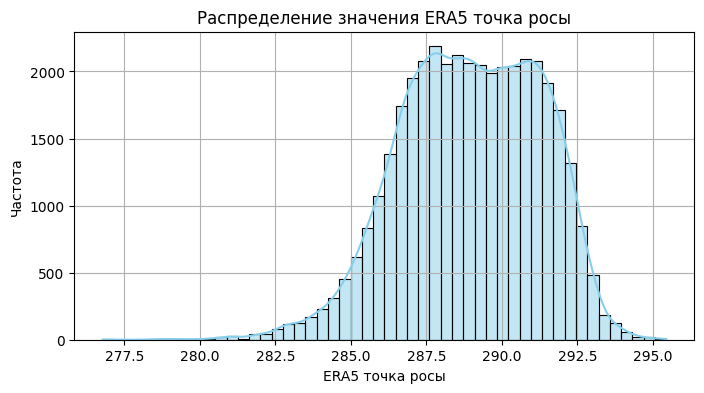

In [79]:
plot_value_distribution(era5_avg, label="ERA5 точка росы")

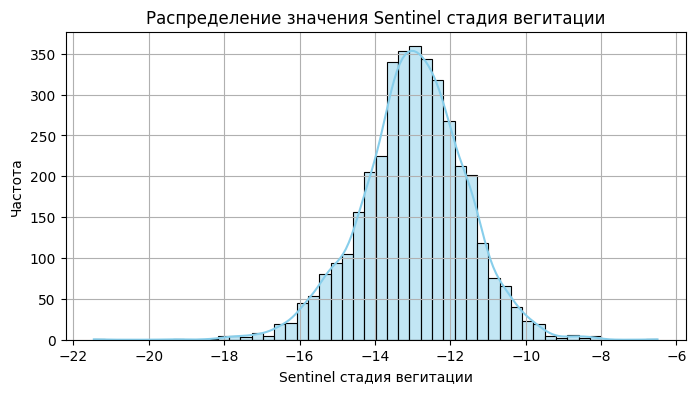

In [80]:
plot_value_distribution(senti_avg, label="Sentinel стадия вегитации")

In [81]:
def elbow_method(data, max_k=10, label=""):
    distortions = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
        distortions.append(kmeans.inertia_)  # сумма квадратов расстояний

    plt.figure(figsize=(8, 4))
    plt.plot(range(1, max_k + 1), distortions, marker='o')
    plt.title(f"Elbow Method for {label}")
    plt.xlabel("Количество кластеров")
    plt.ylabel("Сумма квадратов расстояний (inertia)")
    plt.grid(True)
    plt.show()

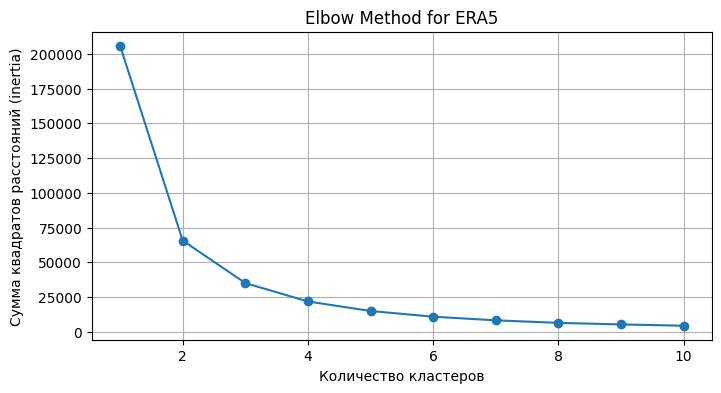

In [82]:
elbow_method(era5_avg[["value"]].values, label="ERA5")

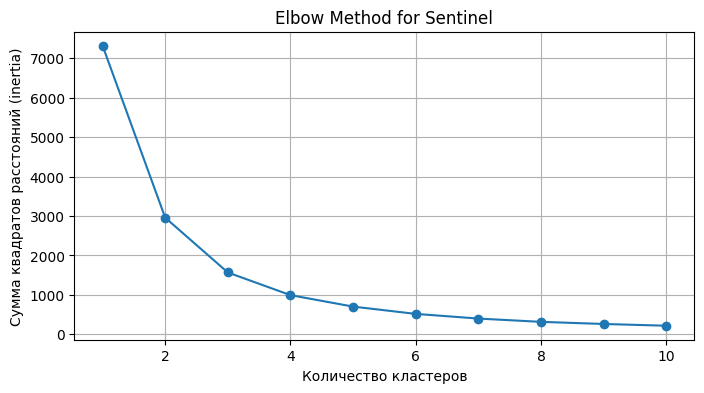

In [83]:
elbow_method(senti_avg[["value"]].values, label="Sentinel")

In [84]:
def silhouette_analysis(data, max_k=10, label=""):
    scores = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
        score = silhouette_score(data, kmeans.labels_)
        scores.append(score)

    plt.figure(figsize=(8, 4))
    plt.plot(range(2, max_k + 1), scores, marker='s', color='green')
    plt.title(f"Silhouette Score for {label}")
    plt.xlabel("Количество кластеров")
    plt.ylabel("Silhouette Score")
    plt.grid(True)
    plt.show()

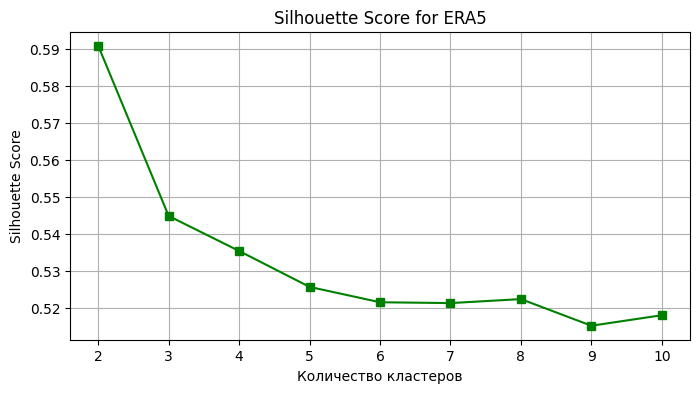

In [85]:
silhouette_analysis(era5_avg[["value"]].values, label="ERA5")

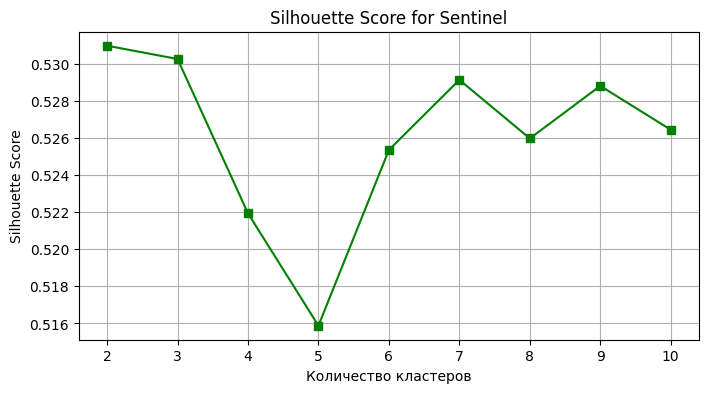

In [86]:
silhouette_analysis(senti_avg[["value"]].values, label="Sentinel")

In [87]:
df_era5.head(3)

,date,product,band,value,farmer_unique_id,site_id
0,2020-01-01,ERA5,dewpoint_2m_temperature,286.8072,2359119,7765
1,2020-01-02,ERA5,dewpoint_2m_temperature,287.9671,2359119,7765
2,2020-01-03,ERA5,dewpoint_2m_temperature,287.9729,2359119,7765


In [88]:
df_era5.isna().sum()

date                0
product             0
band                0
value               0
farmer_unique_id    0
site_id             0
dtype: int64

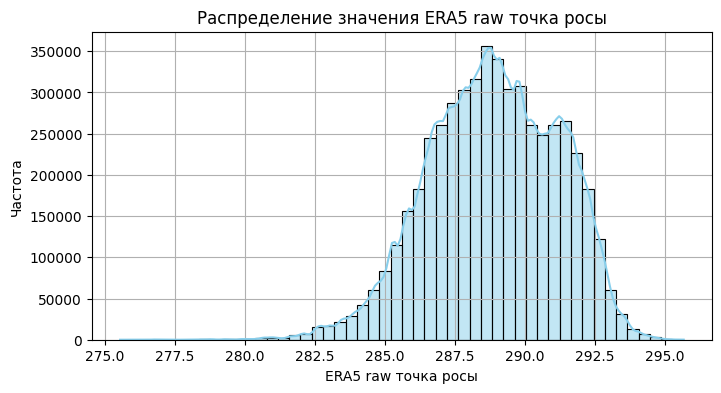

In [89]:
plot_value_distribution(df_era5, label="ERA5 raw точка росы")

In [90]:
df_senti.head(3)

,date,product,band,value,farmer_unique_id,site_id
0,2020-01-11,COPERNICUS/S1_GRD,VH,-14.5043,2635506,1670
1,2020-01-23,COPERNICUS/S1_GRD,VH,-12.1374,2635506,1670
2,2020-02-04,COPERNICUS/S1_GRD,VH,-17.4798,2635506,1670


In [91]:
df_senti.isna().sum()

date                   0
product                0
band                   0
value               4839
farmer_unique_id       0
site_id                0
dtype: int64

In [92]:
df_senti = df_senti.dropna()

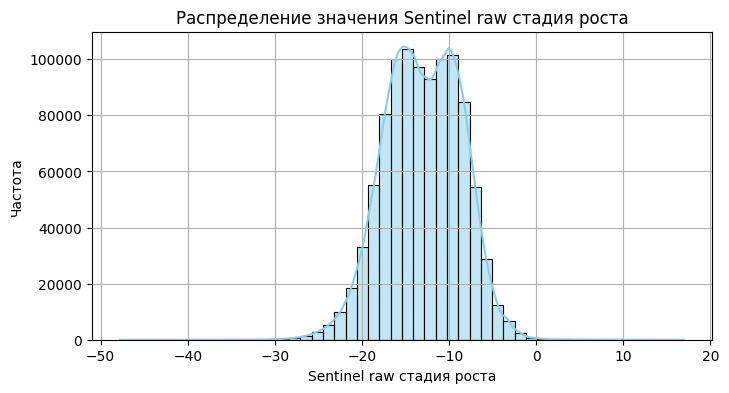

In [93]:
plot_value_distribution(df_senti, label="Sentinel raw стадия роста")

Well, looks like agregation was a mistake. We are working with statistic, so - more experiments - better, no need to calculate mean, use all data to receive better quality.

## Add feature - month

In [94]:
df_era5["month"] = pd.to_datetime(df_era5["date"]).dt.month

In [95]:
df_senti["month"] = pd.to_datetime(df_senti["date"]).dt.month

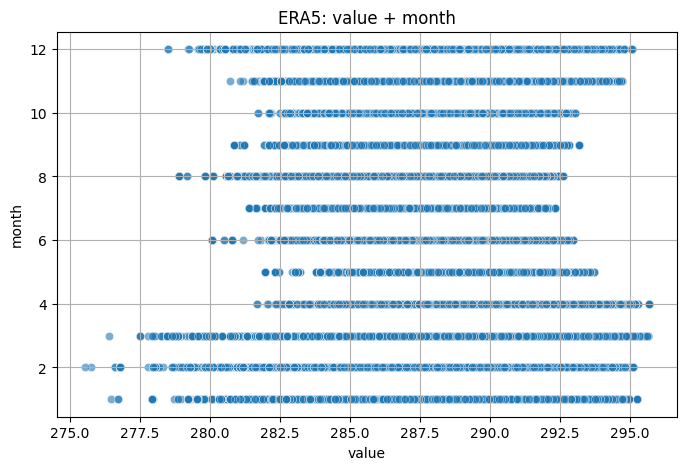

In [96]:
def plot_clusters(df, title="Кластеры"):
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x="value", y="month", palette="tab10", alpha=0.6)
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_clusters(df_era5, "ERA5: value + month")

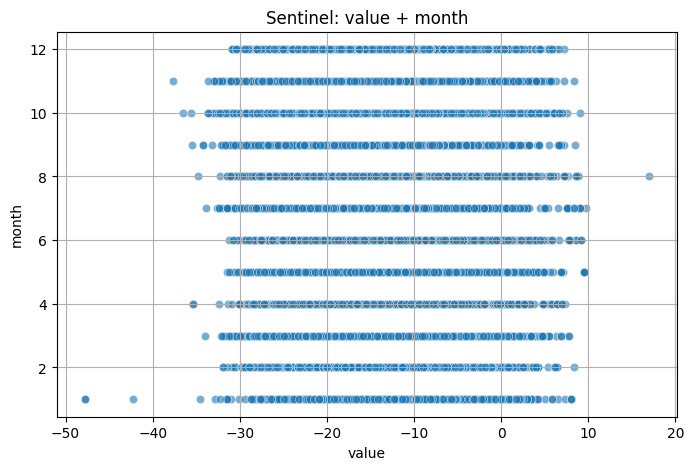

In [97]:
plot_clusters(df_senti, "Sentinel: value + month")

With the addition of the month, some seasonality appeared in the data. There is a risk that it will be more significant during clustering, than value, so we will abandon the month feature for now.

## Evaluating number of clusters

In [98]:
def evaluate_k_range(
    df,
    name="dataset",
    k_range=range(2, 11),
    sample_size=100_000,
    use_minibatch=True,
    batch_size=10_000,
    random_state=42
):
    """
    Efficient evaluation of clustering quality over a range of cluster numbers.

    Parameters:
    - df: DataFrame with a 'value' column
    - name: label for plots
    - k_range: range of cluster numbers to evaluate
    - sample_size: number of samples used for silhouette score estimation
    - use_minibatch: whether to use MiniBatchKMeans (faster for large datasets)
    - batch_size: batch size for MiniBatchKMeans
    - random_state: reproducibility seed

    Output:
    - Elbow and Silhouette score plots
    - Suggested number of clusters based on max silhouette score
    """
    X_full = df[["value"]].dropna().values

    # Create a sample subset for silhouette score to speed up computation
    if len(X_full) > sample_size:
        idx = np.random.choice(len(X_full), size=sample_size, replace=False)
        X_sample = X_full[idx]
    else:
        X_sample = X_full

    inertias = []
    silhouettes = []

    for k in k_range:
        if use_minibatch:
            kmeans = MiniBatchKMeans(
                n_clusters=k,
                batch_size=batch_size,
                n_init=5,
                random_state=random_state
            )
        else:
            from sklearn.cluster import KMeans
            kmeans = KMeans(
                n_clusters=k,
                algorithm="elkan",
                n_init=5,
                random_state=random_state
            )

        labels_full = kmeans.fit_predict(X_full)
        inertias.append(kmeans.inertia_)

        labels_sample = kmeans.predict(X_sample)
        sil_score = silhouette_score(X_sample, labels_sample)
        silhouettes.append(sil_score)

    # Plot Elbow and Silhouette score
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertias, marker='o')
    plt.title(f"Elbow Method: {name}")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouettes, marker='s', color='green')
    plt.title(f"Silhouette Score: {name}")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    best_k = k_range[np.argmax(silhouettes)]
    print(f"📌 Recommended number of clusters for {name}: {best_k} (silhouette = {max(silhouettes):.3f})")

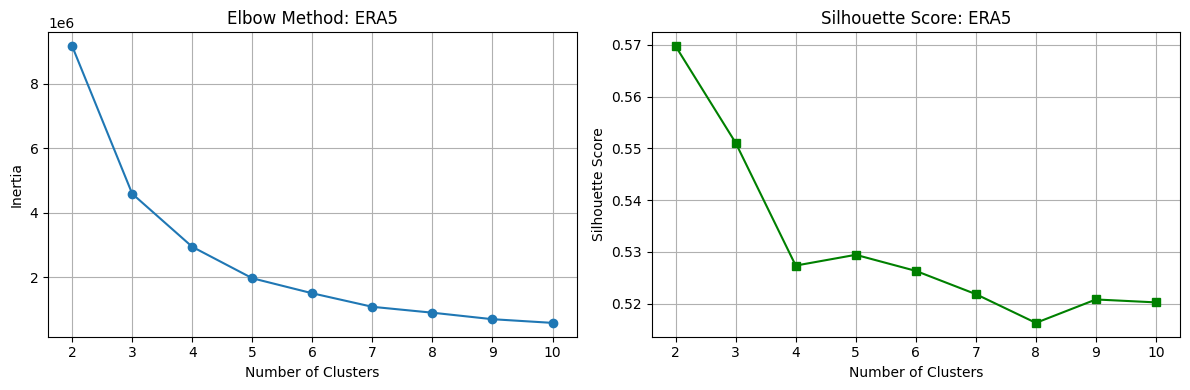

📌 Recommended number of clusters for ERA5: 2 (silhouette = 0.570)


In [99]:
evaluate_k_range(df_era5, name="ERA5")

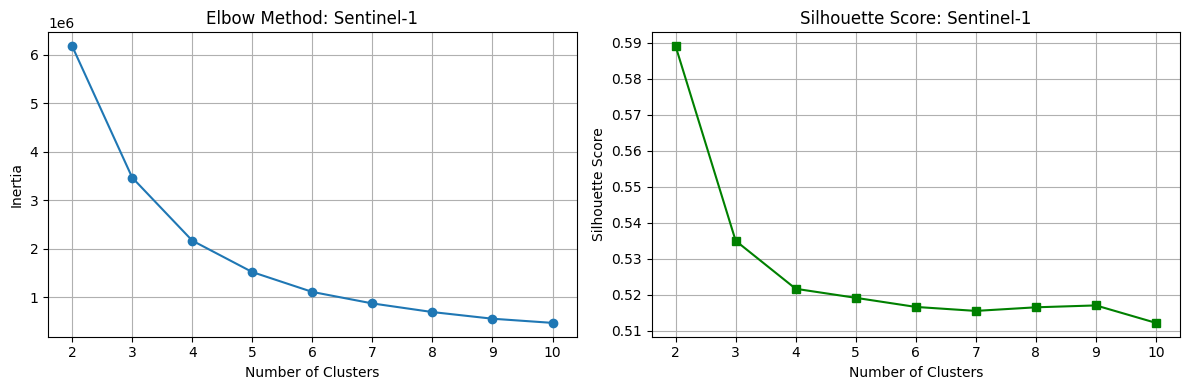

📌 Recommended number of clusters for Sentinel-1: 2 (silhouette = 0.589)


In [100]:
evaluate_k_range(df_senti, name="Sentinel-1")

## Training models

In [101]:
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("WANDB _API_KEY")

wandb.login(key=secret_value_0)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: anastasiia-gapeeva (a-gapeeva) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Moisture

In [102]:
project_name = "growth-and-moisture-kmeans"
run_name = None
model_name = 'moisture'
class_labels=["DR", "MD", "HU", "WL"]

wandb.init(project=project_name, name=run_name or f"{model_name}-kmeans", config={
    "model": "KMeans",
    "n_clusters": len(class_labels),
    "features": ["value"],
    "label_names": class_labels
})

wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250622_172248-0uzfigd6
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run moisture-kmeans
wandb: ⭐️ View project at https://wandb.ai/a-gapeeva/growth-and-moisture-kmeans
wandb: 🚀 View run at https://wandb.ai/a-gapeeva/growth-and-moisture-kmeans/runs/0uzfigd6


In [103]:
# Prepare data
X = df_era5[["value"]].dropna().values

In [104]:
# Train model
model = KMeans(n_clusters=len(class_labels), random_state=42, algorithm="elkan")
labels = model.fit_predict(X)

In [105]:
# Map cluster ids to sorted labels (by cluster center)
cluster_centers = model.cluster_centers_.flatten()
sorted_indices = np.argsort(cluster_centers)
cluster_id_to_label = {
    i: class_labels[sorted_indices.tolist().index(i)]
    for i in range(len(class_labels))
}
predicted_classes = [cluster_id_to_label[label] for label in labels]

In [106]:
# Metrics
ch_score = calinski_harabasz_score(X, labels)
db_score = davies_bouldin_score(X, labels)

In [107]:
print(ch_score)
print(db_score)

14716483.071171273
0.5455106108475842


In [108]:
# sample_size = 100_000
# idx = np.random.choice(len(X), size=sample_size, replace=False)
# silhouette = silhouette_score(X[idx], labels[idx])

In [109]:
wandb.log({
    # "silhouette_score": silhouette,
    "calinski_harabasz": ch_score,
    "davies_bouldin": db_score,
    "cluster_centers": {
        cluster_id_to_label[i]: float(cluster_centers[i])
        for i in range(len(class_labels))
    }
})

In [110]:
# Output dataframe
df_moisture_labeled = df_era5.copy()
df_moisture_labeled["cluster"] = labels
df_moisture_labeled["class"] = predicted_classes

# Log sample table
# wandb_table = wandb.Table(dataframe=df_out[["value", "cluster", "class"]].sample(n=min(1000, len(df_out))))
# wandb.log({f"{model_name}_clusters": wandb_table})

# Save and log model file
model_path = f"{model_name}_kmeans.joblib"
joblib.dump(model, model_path)

artifact = wandb.Artifact(
    name=f"{model_name}-kmeans",
    type="model",
    description=f"KMeans model for {model_name} clustering",
    metadata={"n_clusters": model.n_clusters}
)

artifact.add_file(model_path)

wandb.log_artifact(artifact)

<Artifact moisture-kmeans>

In [111]:
def plot_clusters_by_value(
    df_labeled: pd.DataFrame,
    title: str = "Clustered Values",
    color_by: str = "class",  # or "cluster"
    palette: str = "tab10",
    sample_size: int = 5000,
    wandb_key: str = "cluster_plot"
):
    """
    Plots and logs a scatterplot of clustered values with optional wandb integration.

    Parameters:
        df_labeled: DataFrame with 'value' and 'class' or 'cluster' columns
        title: Plot title
        color_by: "class" or "cluster" (column to color points by)
        palette: Seaborn palette name
        sample_size: Max number of points to plot
        wandb_key: Key under which to log the plot to wandb
    """
    df_plot = df_labeled.sample(n=min(sample_size, len(df_labeled))).copy()
    df_plot["y"] = 0.1 * np.random.randn(len(df_plot))  # jitter

    plt.figure(figsize=(10, 4))
    sns.scatterplot(
        data=df_plot,
        x="value",
        y="y",
        hue=color_by,
        palette=palette,
        alpha=0.5,
        s=20
    )
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("")
    plt.yticks([])
    plt.grid(True)
    plt.tight_layout()

    # 📤 Log to wandb
    wandb.log({wandb_key: wandb.Image(plt)})

    plt.show()
    plt.close()


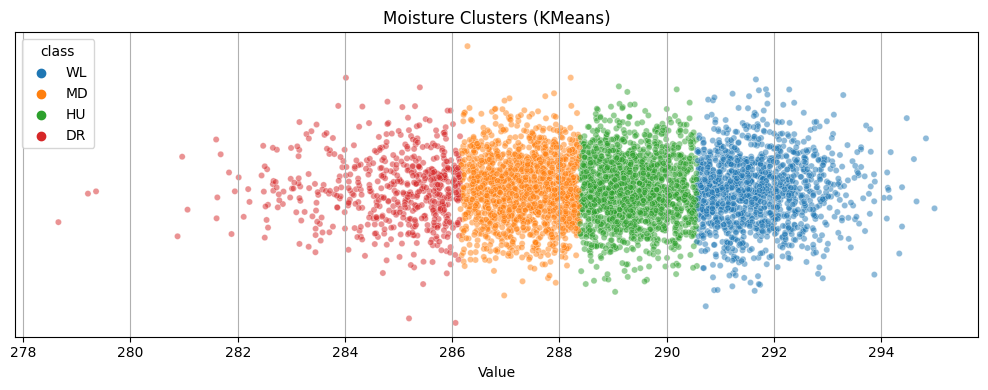

In [112]:
plot_clusters_by_value(
    df_moisture_labeled,
    title="Moisture Clusters (KMeans)",
    color_by="class"
)

In [113]:
wandb.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb: calinski_harabasz ▁
wandb:    davies_bouldin ▁
wandb: 
wandb: Run summary:
wandb: calinski_harabasz 14716483.07117
wandb:    davies_bouldin 0.54551
wandb: 
wandb: 🚀 View run moisture-kmeans at: https://wandb.ai/a-gapeeva/growth-and-moisture-kmeans/runs/0uzfigd6
wandb: ⭐️ View project at: https://wandb.ai/a-gapeeva/growth-and-moisture-kmeans
wandb: Synced 5 W&B file(s), 1 media file(s), 2 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250622_172248-0uzfigd6/logs


## Growth stage

In [114]:
model_name = 'growth'
class_labels=["S", "V", "F", "M"]
run_name=None

wandb.init(project=project_name, name=run_name or f"{model_name}-kmeans", config={
    "model": "KMeans",
    "n_clusters": len(class_labels),
    "features": ["value"],
    "label_names": class_labels
})

wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250622_172329-95iemi33
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run growth-kmeans
wandb: ⭐️ View project at https://wandb.ai/a-gapeeva/growth-and-moisture-kmeans
wandb: 🚀 View run at https://wandb.ai/a-gapeeva/growth-and-moisture-kmeans/runs/95iemi33


In [115]:
# Prepare data
X = df_senti[["value"]].dropna().values

In [116]:
# Train model
model = KMeans(n_clusters=len(class_labels), random_state=42, algorithm="elkan")
labels = model.fit_predict(X)

In [117]:
# Map cluster ids to sorted labels (by cluster center)
cluster_centers = model.cluster_centers_.flatten()
sorted_indices = np.argsort(cluster_centers)
cluster_id_to_label = {
    i: class_labels[sorted_indices.tolist().index(i)]
    for i in range(len(class_labels))
}
predicted_classes = [cluster_id_to_label[label] for label in labels]

In [118]:
# Metrics
# silhouette = silhouette_score(X, labels)
ch_score = calinski_harabasz_score(X, labels)
db_score = davies_bouldin_score(X, labels)

wandb.log({
    # "silhouette_score": silhouette,
    "calinski_harabasz": ch_score,
    "davies_bouldin": db_score,
    "cluster_centers": {
        cluster_id_to_label[i]: float(cluster_centers[i])
        for i in range(len(class_labels))
    }
})

In [119]:
# Output dataframe
df_out = df_senti.copy()
df_out["cluster"] = labels
df_out["class"] = predicted_classes

# Log sample table
# wandb_table = wandb.Table(dataframe=df_out[["value", "cluster", "class"]].sample(n=min(1000, len(df_out))))
# wandb.log({f"{model_name}_clusters": wandb_table})

# Save and log model file
model_path = f"{model_name}_kmeans.joblib"
joblib.dump(model, model_path)

artifact = wandb.Artifact(
    name=f"{model_name}-kmeans",
    type="model",
    description=f"KMeans model for {model_name} clustering",
    metadata={"n_clusters": model.n_clusters}
)

artifact.add_file(model_path)

wandb.log_artifact(artifact)

<Artifact growth-kmeans>

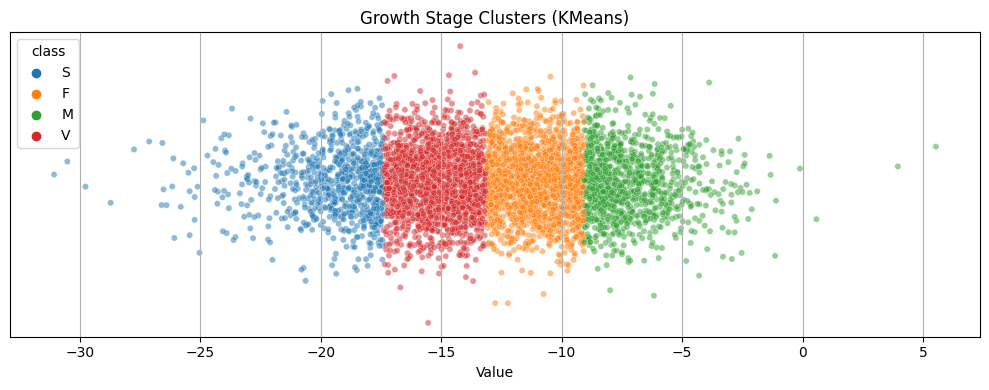

In [120]:
plot_clusters_by_value(
    df_out,
    title="Growth Stage Clusters (KMeans)",
    color_by="class"
)

In [121]:
wandb.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb: calinski_harabasz ▁
wandb:    davies_bouldin ▁
wandb: 
wandb: Run summary:
wandb: calinski_harabasz 2586197.9807
wandb:    davies_bouldin 0.58347
wandb: 
wandb: 🚀 View run growth-kmeans at: https://wandb.ai/a-gapeeva/growth-and-moisture-kmeans/runs/95iemi33
wandb: ⭐️ View project at: https://wandb.ai/a-gapeeva/growth-and-moisture-kmeans
wandb: Synced 5 W&B file(s), 1 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250622_172329-95iemi33/logs


## Moisture + month

In [122]:
df_senti["month"] = pd.to_datetime(df_senti["date"]).dt.month

In [123]:
df_senti["month_sin"] = np.sin(2 * np.pi * df_senti["month"] / 12)
df_senti["month_cos"] = np.cos(2 * np.pi * df_senti["month"] / 12)

In [124]:
features_senti = df_senti[["value", "month_sin", "month_cos"]]

In [125]:
features_senti.isna().sum()

value        0
month_sin    0
month_cos    0
dtype: int64

In [126]:
scaler = StandardScaler()
X_senti = scaler.fit_transform(features_senti)

In [127]:
model_name = 'growth-month'
class_labels=["S", "V", "F", "M"]
run_name=None

wandb.init(project=project_name, name=run_name or f"{model_name}-kmeans", config={
    "model": "KMeans",
    "n_clusters": len(class_labels),
    "features": ["value"],
    "label_names": class_labels
})

wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250622_172340-4ywyywpy
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run growth-month-kmeans
wandb: ⭐️ View project at https://wandb.ai/a-gapeeva/growth-and-moisture-kmeans
wandb: 🚀 View run at https://wandb.ai/a-gapeeva/growth-and-moisture-kmeans/runs/4ywyywpy


In [128]:
# Train model
model = KMeans(n_clusters=len(class_labels), random_state=42, algorithm="elkan")
labels = model.fit_predict(X_senti)

In [129]:
# Map cluster ids to sorted labels (by cluster center)
value_centers = model.cluster_centers_[:, 0]  # колонка 'value'
sorted_indices = np.argsort(value_centers)

cluster_id_to_label = {
    cluster_id: class_labels[i]
    for i, cluster_id in enumerate(sorted_indices)
}

predicted_classes = [cluster_id_to_label[label] for label in labels]

In [130]:
# Metrics
# silhouette = silhouette_score(X, labels)
ch_score = calinski_harabasz_score(X, labels)
db_score = davies_bouldin_score(X, labels)

wandb.log({
    # "silhouette_score": silhouette,
    "calinski_harabasz": ch_score,
    "davies_bouldin": db_score,
    "cluster_centers": {
        cluster_id_to_label[i]: float(cluster_centers[i])
        for i in range(len(class_labels))
    }
})

In [131]:
# Output dataframe
df_out = df_senti.copy()
df_out["cluster"] = labels
df_out["class"] = predicted_classes

# Log sample table
# wandb_table = wandb.Table(dataframe=df_out[["value", "cluster", "class"]].sample(n=min(1000, len(df_out))))
# wandb.log({f"{model_name}_clusters": wandb_table})

# Save and log model file
model_path = f"{model_name}_kmeans.joblib"
joblib.dump(model, model_path)

artifact = wandb.Artifact(
    name=f"{model_name}-kmeans",
    type="model",
    description=f"KMeans model for {model_name} clustering",
    metadata={"n_clusters": model.n_clusters}
)

artifact.add_file(model_path)

wandb.log_artifact(artifact)

<Artifact growth-month-kmeans>

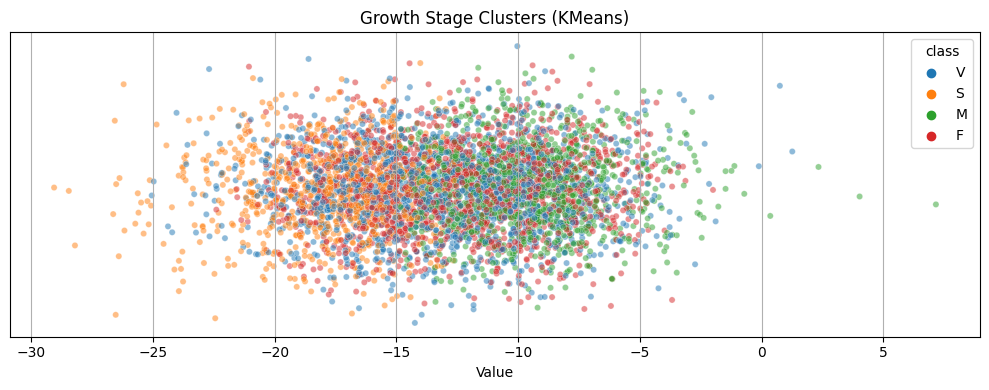

In [132]:
plot_clusters_by_value(
    df_out,
    title="Growth Stage Clusters (KMeans)",
    color_by="class"
)

In [133]:
wandb.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb: calinski_harabasz ▁
wandb:    davies_bouldin ▁
wandb: 
wandb: Run summary:
wandb: calinski_harabasz 170683.94475
wandb:    davies_bouldin 5.12379
wandb: 
wandb: 🚀 View run growth-month-kmeans at: https://wandb.ai/a-gapeeva/growth-and-moisture-kmeans/runs/4ywyywpy
wandb: ⭐️ View project at: https://wandb.ai/a-gapeeva/growth-and-moisture-kmeans
wandb: Synced 5 W&B file(s), 1 media file(s), 2 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250622_172340-4ywyywpy/logs
